# Outliers for ECOD

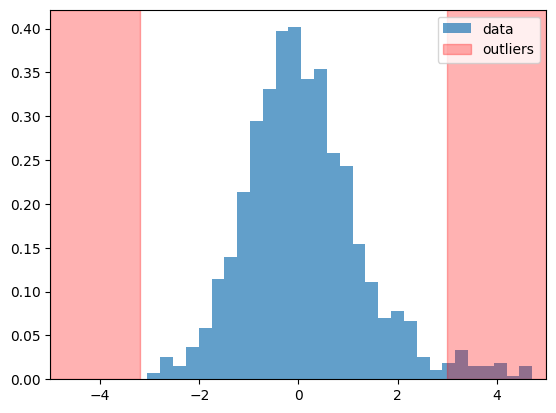

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic dataset
np.random.seed(0)
n_samples = 1000
mean, std = 0, 1
data = np.random.normal(mean, std, n_samples)

# Add outliers
outliers = np.random.normal(mean + 3 * std, std, 50)
data = np.concatenate((data, outliers))

# Plot histogram
plt.hist(data, bins=30, density=True, alpha=0.7, label='data')
plt.axvspan(-5, -3.2, color='r', alpha=0.3, label='outliers')
plt.axvspan(3, 5, color='r', alpha=0.3, label=None)
plt.xlim(-5, 5)
plt.legend()
plt.show()


In [9]:
%pip install pyod

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ----------------------------- ---------- 2.1/2.8 MB 11.6 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 10.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   -- ------------------------------------- 2.1/30.3 MB 11.9 MB/s eta 0:00:03
   ------ --------------------------------- 4.7/30.3 MB 11.8 MB/s eta 0:00:03
   --------- ------------------------------ 7.1/30.3 MB 11.8 MB/s eta 0:00:02
   ------------ --------------------------- 9.4/30.3 MB 11.8 MB/s eta 0:00:02
   --------------- ------------------------ 11.8/30.3 MB 11.8 MB/s eta 0:00:02
   ------------------- -------------------- 14.4/30.3 MB 11.8 MB/s eta 0:00:02
   ---------------------- ----------------- 16.8/30.3 MB 11.8 MB/s eta 0:00:02
   ------------------------- -------------- 19.4/30.3 MB 11.8 MB/s eta 0:00:01
   ---

Generating time series with local and global anomalies...
Creating separate anomaly detection plots...
Local anomalies plot saved to: ./local_anomalies_plot.png


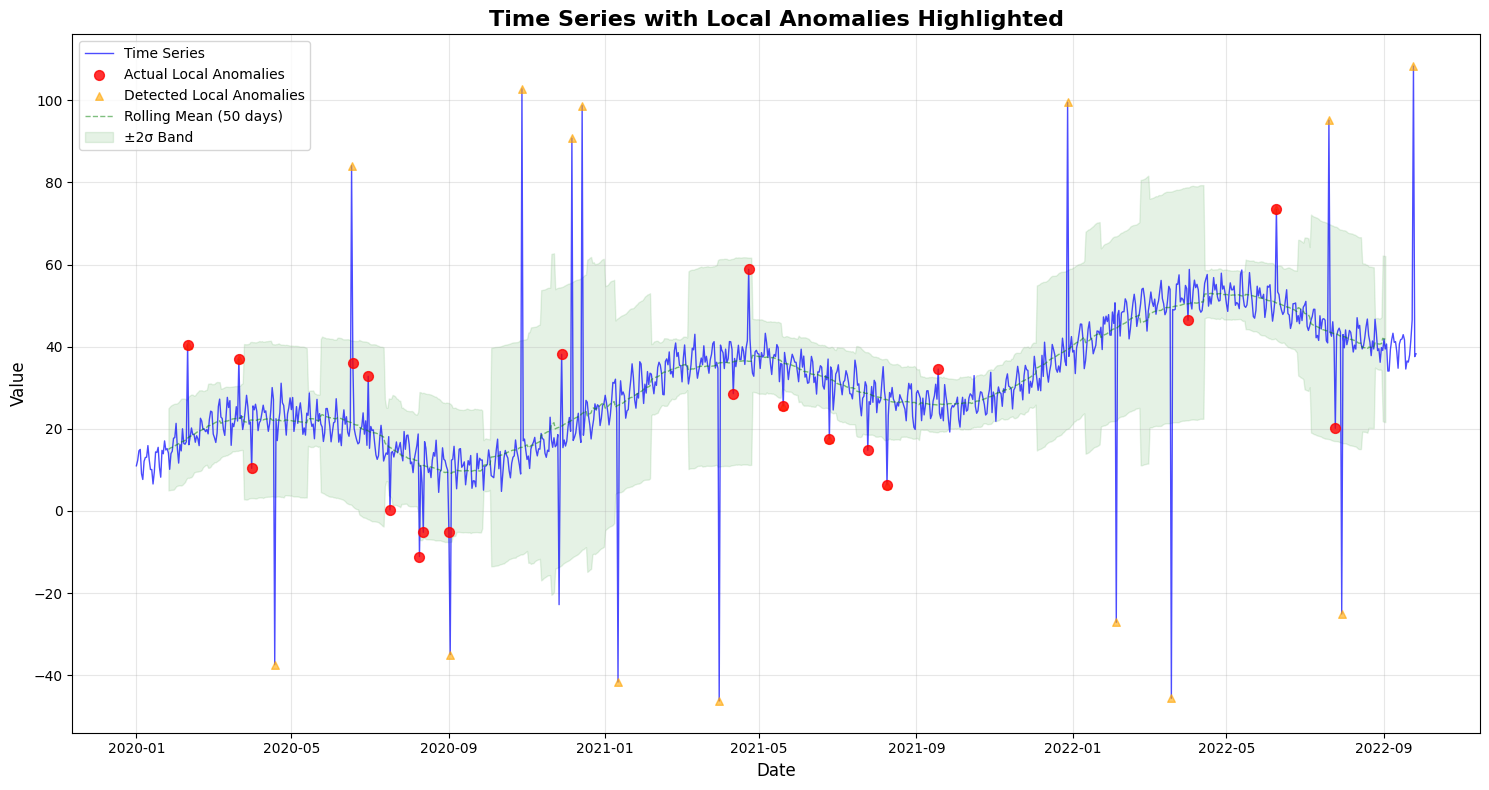

Global anomalies plot saved to: ./global_anomalies_plot.png


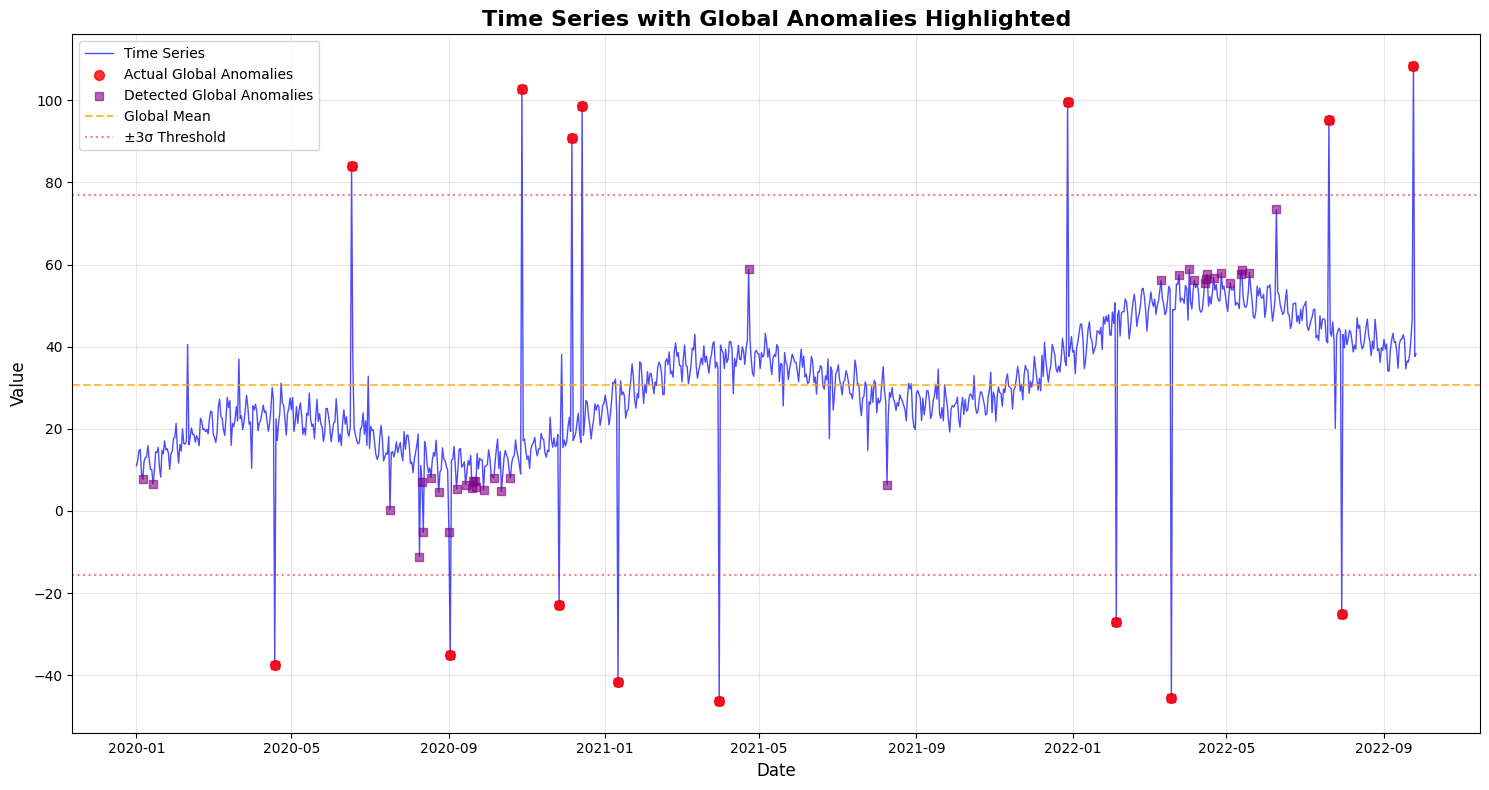

=== Anomaly Detection Performance Analysis ===

LOCAL ANOMALIES:
  True Positives: 6
  False Positives: 14
  False Negatives: 14
  Precision: 0.300
  Recall: 0.300

GLOBAL ANOMALIES:
  True Positives: 15
  False Positives: 35
  False Negatives: 0
  Precision: 0.300
  Recall: 1.000

=== Time Series Summary ===
Total data points: 1000
Actual local anomalies: 20
Actual global anomalies: 15
Detected local anomalies: 20
Detected global anomalies: 50

=== Sample Data ===
        date      value  base_value  is_local_anomaly  is_global_anomaly
0 2020-01-01  10.993428   10.993428             False              False
1 2020-01-02  12.281022   12.281022             False              False
2 2020-01-03  14.644221   14.644221             False              False
3 2020-01-04  14.983675   14.983675             False              False
4 2020-01-05   9.077756    9.077756             False              False
5 2020-01-06   7.666204    7.666204             False              False
6 2020-01-07  12.08

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyod.models.ecod import ECOD

# Generate 1D synthetic data (normal distribution + outliers)
np.random.seed(42)
normal_data = np.random.normal(loc=0, scale=1, size=100)
outliers = np.array([5, 6, -4.5])  # clear outliers
X = np.concatenate([normal_data, outliers]).reshape(-1, 1)

# Fit ECOD
model = ECOD()
model.fit(X)
scores = model.decision_scores_

# Sort data for ECDF
X_sorted = np.sort(X.flatten())
ecdf = np.arange(1, len(X_sorted)+1) / len(X_sorted)

# Get thresholds or color by score
is_outlier = model.labels_.astype(bool)

# Plot
plt.figure(figsize=(10, 5))

# ECDF Plot
X_regular_sorted = [x for x in X_sorted if not x in outliers]
X_outlier_sorted = [x for x in X_sorted if x in outliers]
ecdf_regular = [ecdf[X_sorted == x] for x in X_sorted if not x in outliers]
ecdf_outlier = [ecdf[X_sorted == x] for x in X_sorted if x in outliers]
plt.subplot(1, 2, 1)
plt.plot(X_sorted, ecdf, linestyle='-', label='ECDF')
plt.title("Empirical CDF")
plt.xlabel("Value")
plt.ylabel("ECDF")
plt.grid(True)

# Show outliers
plt.scatter(X_regular_sorted, ecdf_regular, marker='o', 
            color='blue', label='Regular Data')
plt.scatter(X_outlier_sorted, ecdf_outlier, marker='o', s=100, color='red', label='Real outliers')
plt.scatter(X[is_outlier], np.interp(X[is_outlier], X_sorted, ecdf), 
            color='orange', label='Detected Outliers')

plt.legend()

# Score plot
plt.subplot(1, 2, 2)
plt.scatter(X, scores, c=['red' if out else 'blue' for out in is_outlier])
plt.title("ECOD Scores")
plt.xlabel("Value")
plt.ylabel("Outlier Score")
plt.grid(True)

plt.tight_layout()
plt.show()


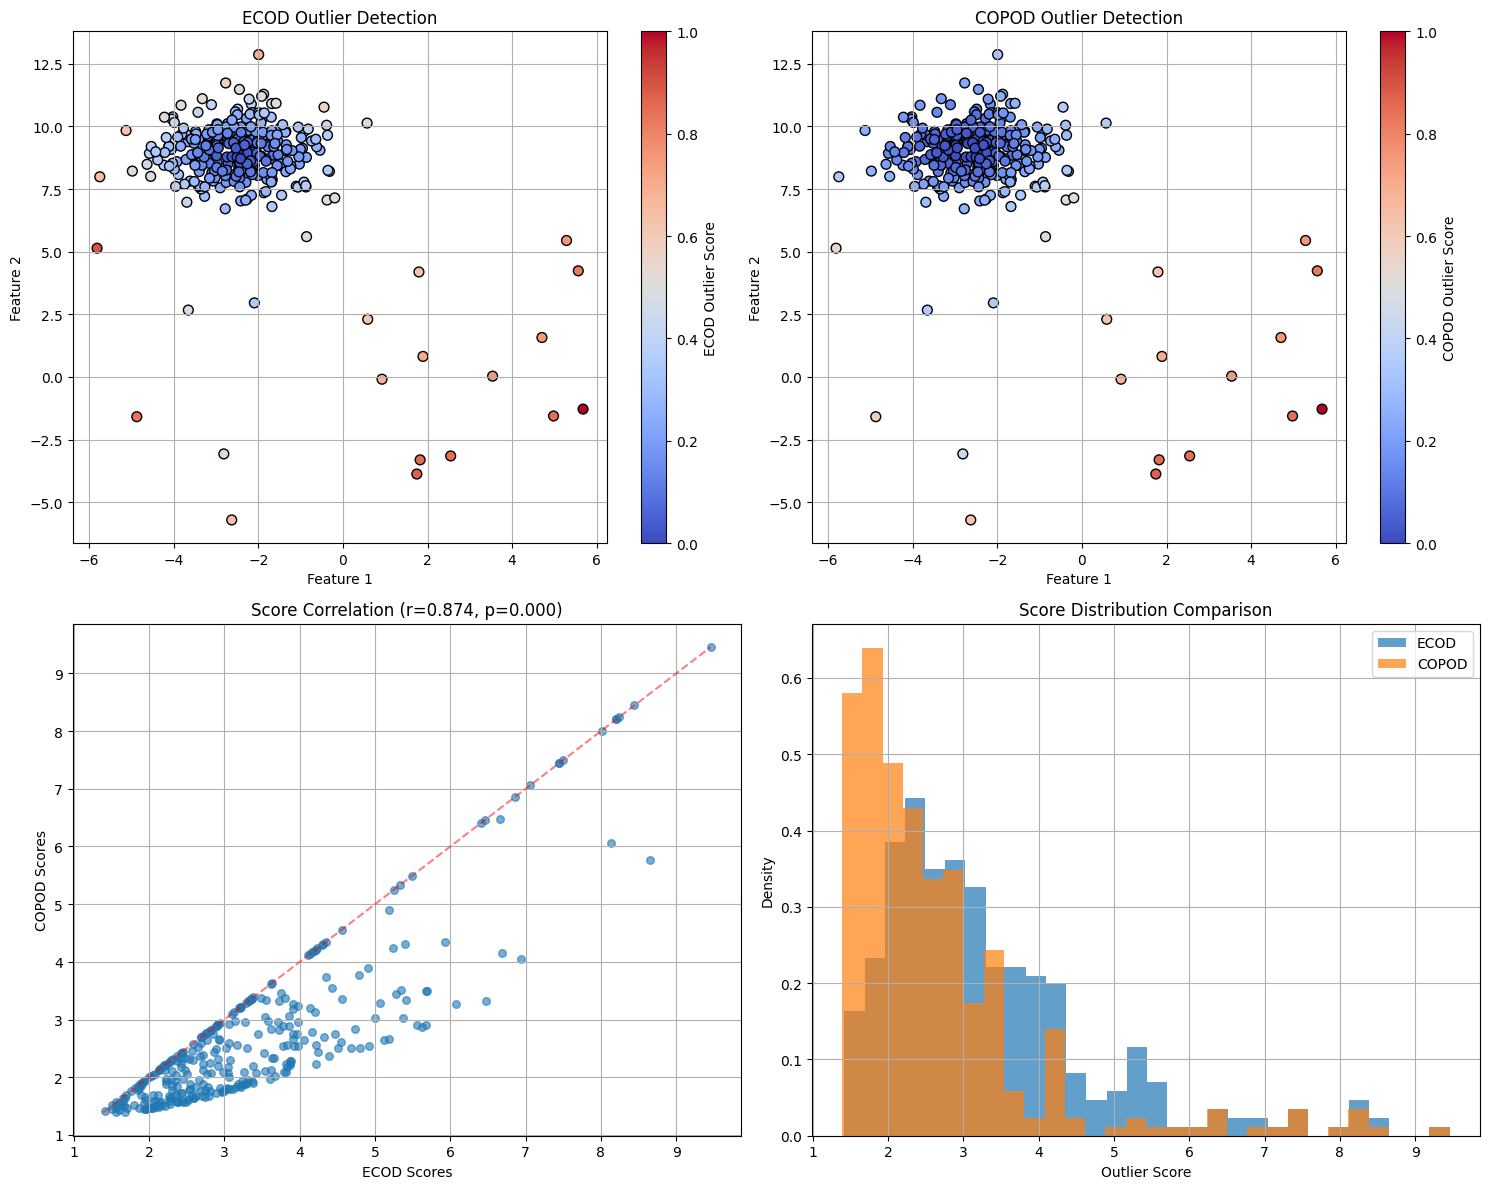

=== COMPARISON SUMMARY ===
Dataset size: 320 points (2 features)
Added outliers: 20 points

ECOD Statistics:
  Mean score: 3.3431
  Std score: 1.4613
  Min score: 1.4179
  Max score: 9.4572

COPOD Statistics:
  Mean score: 2.6597
  Std score: 1.3510
  Min score: 1.3885
  Max score: 9.4572

Correlation between methods: 0.8743 (p-value: 0.0000)

Top 10 outliers overlap: 8/10
Agreement on top outliers: 80.0%


In [76]:
import numpy as np
import matplotlib.pyplot as plt
from pyod.models.ecod import ECOD
from pyod.models.copod import COPOD
from sklearn.datasets import make_blobs
from scipy.stats import pearsonr

# Generate a 2D dataset with some natural clusters
X, _ = make_blobs(n_samples=300, centers=1, cluster_std=1.0, random_state=42)
# Add some outliers
outliers = np.random.uniform(low=-6, high=6, size=(20, 2))
X = np.vstack([X, outliers])

# Fit both models
ecod_clf = ECOD()
copod_clf = COPOD()

ecod_clf.fit(X)
copod_clf.fit(X)

# Get outlier scores
ecod_scores = ecod_clf.decision_scores_
copod_scores = copod_clf.decision_scores_

# Normalize scores for visualization
ecod_normalized = (ecod_scores - ecod_scores.min()) / (ecod_scores.max() - ecod_scores.min())
copod_normalized = (copod_scores - copod_scores.min()) / (copod_scores.max() - copod_scores.min())

# Calculate correlation between the two methods
correlation, p_value = pearsonr(ecod_scores, copod_scores)

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ECOD visualization
scatter1 = axes[0, 0].scatter(X[:, 0], X[:, 1], c=ecod_normalized, cmap='coolwarm', s=50, edgecolor='k')
axes[0, 0].set_title("ECOD Outlier Detection")
axes[0, 0].set_xlabel("Feature 1")
axes[0, 0].set_ylabel("Feature 2")
axes[0, 0].grid(True)
plt.colorbar(scatter1, ax=axes[0, 0], label='ECOD Outlier Score')

# COPOD visualization
scatter2 = axes[0, 1].scatter(X[:, 0], X[:, 1], c=copod_normalized, cmap='coolwarm', s=50, edgecolor='k')
axes[0, 1].set_title("COPOD Outlier Detection")
axes[0, 1].set_xlabel("Feature 1")
axes[0, 1].set_ylabel("Feature 2")
axes[0, 1].grid(True)
plt.colorbar(scatter2, ax=axes[0, 1], label='COPOD Outlier Score')

# Score comparison scatter plot
axes[1, 0].scatter(ecod_scores, copod_scores, alpha=0.6, s=30)
axes[1, 0].set_xlabel("ECOD Scores")
axes[1, 0].set_ylabel("COPOD Scores")
axes[1, 0].set_title(f"Score Correlation (r={correlation:.3f}, p={p_value:.3f})")
axes[1, 0].grid(True)
# Add diagonal line for reference
min_score = min(ecod_scores.min(), copod_scores.min())
max_score = max(ecod_scores.max(), copod_scores.max())
axes[1, 0].plot([min_score, max_score], [min_score, max_score], 'r--', alpha=0.5)

# Score distribution comparison
axes[1, 1].hist(ecod_scores, bins=30, alpha=0.7, label='ECOD', density=True)
axes[1, 1].hist(copod_scores, bins=30, alpha=0.7, label='COPOD', density=True)
axes[1, 1].set_xlabel("Outlier Score")
axes[1, 1].set_ylabel("Density")
axes[1, 1].set_title("Score Distribution Comparison")
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== COMPARISON SUMMARY ===")
print(f"Dataset size: {X.shape[0]} points ({X.shape[1]} features)")
print(f"Added outliers: 20 points")
print()
print("ECOD Statistics:")
print(f"  Mean score: {ecod_scores.mean():.4f}")
print(f"  Std score: {ecod_scores.std():.4f}")
print(f"  Min score: {ecod_scores.min():.4f}")
print(f"  Max score: {ecod_scores.max():.4f}")
print()
print("COPOD Statistics:")
print(f"  Mean score: {copod_scores.mean():.4f}")
print(f"  Std score: {copod_scores.std():.4f}")
print(f"  Min score: {copod_scores.min():.4f}")
print(f"  Max score: {copod_scores.max():.4f}")
print()
print(f"Correlation between methods: {correlation:.4f} (p-value: {p_value:.4f})")

# Identify top outliers from each method
n_outliers = 10
ecod_top_indices = np.argsort(ecod_scores)[-n_outliers:]
copod_top_indices = np.argsort(copod_scores)[-n_outliers:]

print(f"\nTop {n_outliers} outliers overlap: {len(set(ecod_top_indices) & set(copod_top_indices))}/{n_outliers}")
print(f"Agreement on top outliers: {len(set(ecod_top_indices) & set(copod_top_indices))/n_outliers*100:.1f}%")

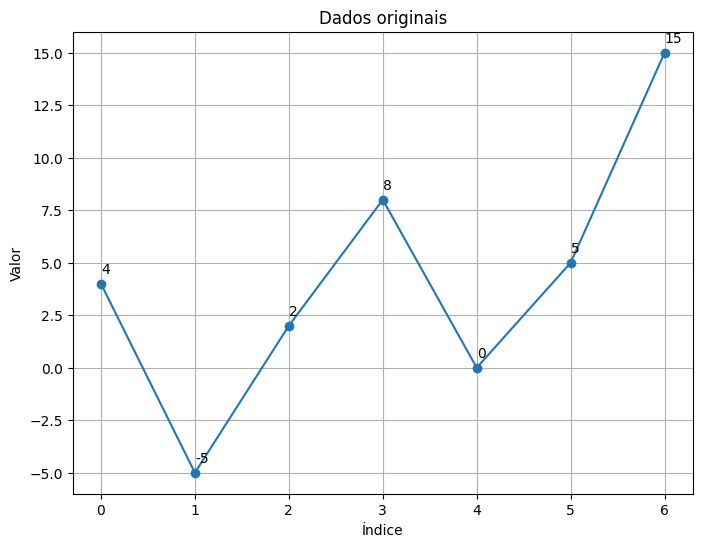

[-5  0  2  4  5  8 15]


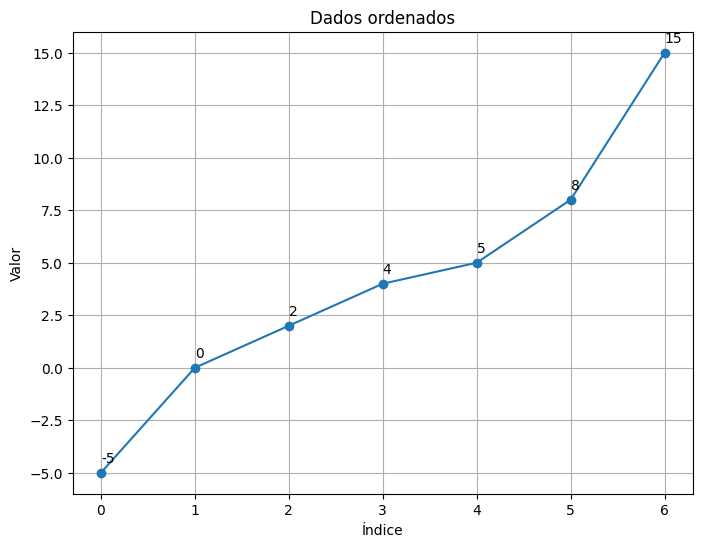

[0 1 2 3 4 5 6]


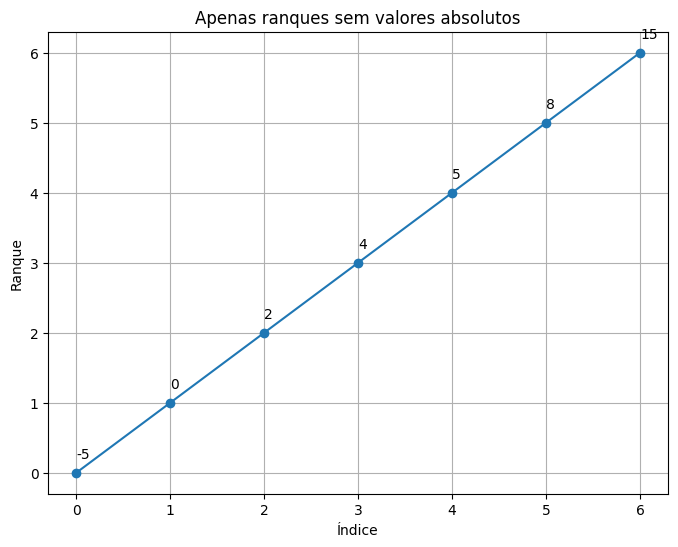

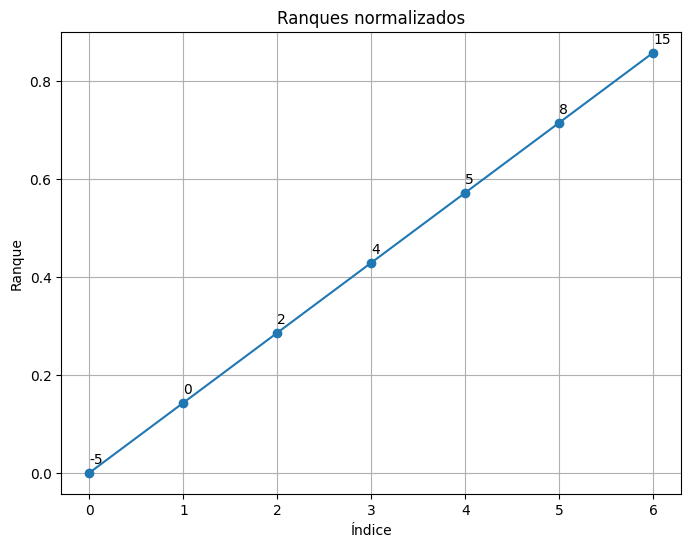

ValueError: Expected 2D array, got 1D array instead:
array=[ 4 -5  2  8  0  5 15].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [74]:
# A simple example to demonstrate how ECOD works
x = np.array([4,-5,2,8,0,5,15])

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(x, 'o-')
for i, txt in enumerate(x):
    plt.annotate(txt, (i, x[i] + 0.5))
plt.title("Dados originais")
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.grid(True)
plt.show()

# Sort the data
ordenado = np.sort(x)
print(ordenado)
plt.figure(figsize=(8, 6))
plt.plot(ordenado, 'o-')
for i, txt in enumerate(ordenado):
    plt.annotate(txt, (i, ordenado[i] + 0.5))
plt.title("Dados ordenados")
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.grid(True)
plt.show()

# Calcula ranks apenas
ranks = np.argsort(ordenado)
print(ranks)
plt.figure(figsize=(8, 6))
plt.plot(ranks, 'o-')
# add labels
for i, txt in enumerate(ordenado):
    plt.annotate(txt, (i, i+0.2))
plt.title("Apenas ranques sem valores absolutos")
plt.xlabel("Índice")
plt.ylabel("Ranque")
plt.grid(True)
plt.show()


# Calcula rank normalizado
rank_normalizado = ranks / len(ranks)
plt.figure(figsize=(8, 6))
plt.plot(rank_normalizado, 'o-')
# add labels
for i, txt in enumerate(ordenado):
    plt.annotate(txt, (i, rank_normalizado[i]+0.02))
plt.title("Ranques normalizados")
plt.xlabel("Índice")
plt.ylabel("Ranque")
plt.grid(True)
plt.show()

# Calculate the ECDF
ecdf = ECOD().fit(x).ecdf_

# Plot the ECDF
plt.figure(figsize=(8, 6))
plt.plot(x, ecdf, 'o-')
plt.title("ECDF")
plt.xlabel("Valor")
plt.ylabel("Probability")
plt.grid(True)
plt.show()

# Calculate the outlier scores
outlier_scores = ECOD().fit(x).decision_scores_

# Plot the outlier scores
plt.figure(figsize=(8, 6))
plt.plot(x, outlier_scores, 'o-')
plt.title("Outlier Scores")
plt.xlabel("Valor")
plt.ylabel("Score")
plt.grid(True)
plt.show()

Generating time series with local and global anomalies...
Creating separate anomaly detection plots...
Local anomalies plot saved to: ./local_anomalies_plot.png


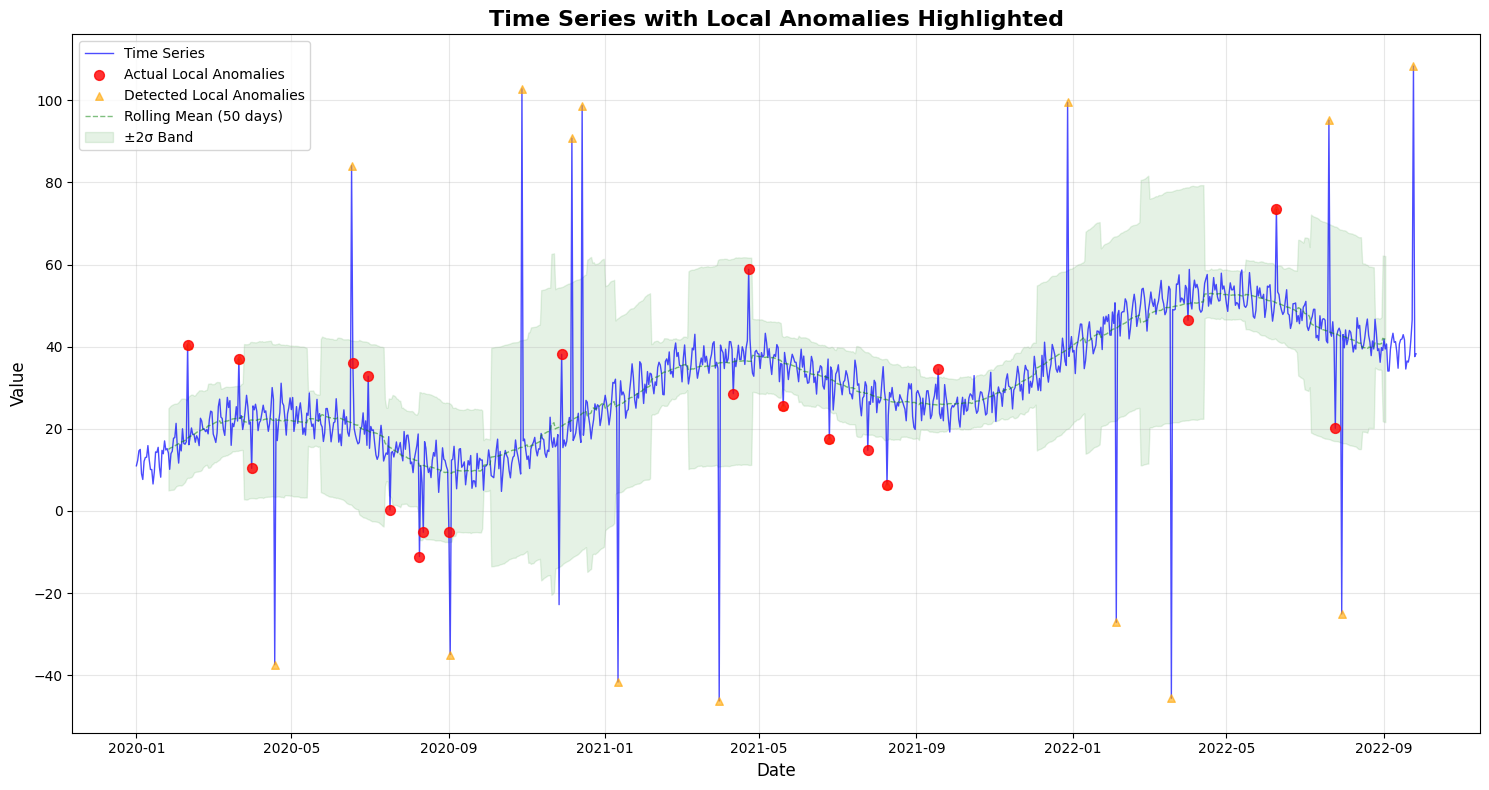

Global anomalies plot saved to: ./global_anomalies_plot.png


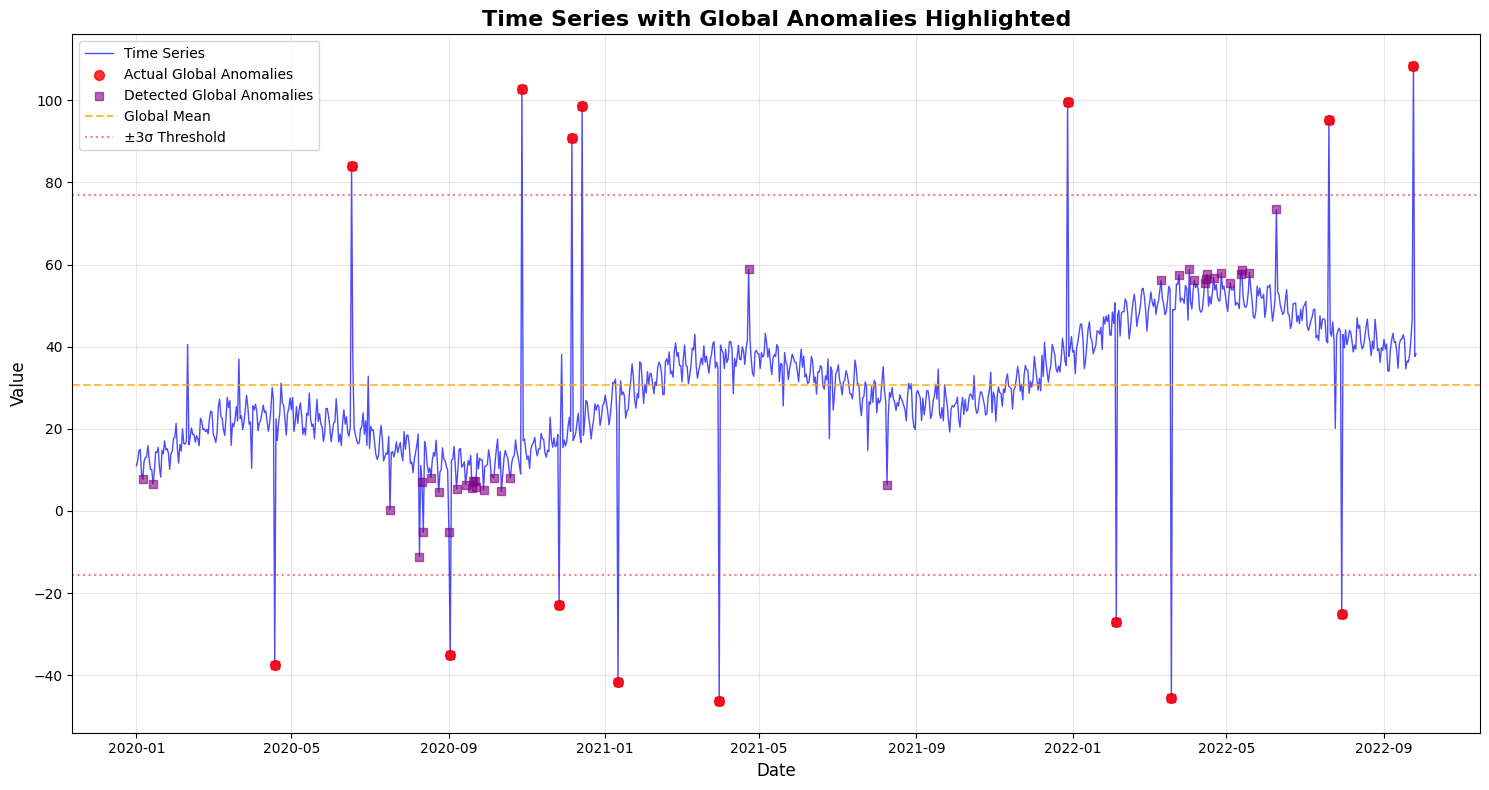

=== Anomaly Detection Performance Analysis ===

LOCAL ANOMALIES:
  True Positives: 6
  False Positives: 14
  False Negatives: 14
  Precision: 0.300
  Recall: 0.300

GLOBAL ANOMALIES:
  True Positives: 15
  False Positives: 35
  False Negatives: 0
  Precision: 0.300
  Recall: 1.000

=== Time Series Summary ===
Total data points: 1000
Actual local anomalies: 20
Actual global anomalies: 15
Detected local anomalies: 20
Detected global anomalies: 50

=== Sample Data ===
        date      value  base_value  is_local_anomaly  is_global_anomaly
0 2020-01-01  10.993428   10.993428             False              False
1 2020-01-02  12.281022   12.281022             False              False
2 2020-01-03  14.644221   14.644221             False              False
3 2020-01-04  14.983675   14.983675             False              False
4 2020-01-05   9.077756    9.077756             False              False
5 2020-01-06   7.666204    7.666204             False              False
6 2020-01-07  12.08

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

def create_time_series_with_anomalies(n_points=1000):
    """
    Create a time series with trend, seasonality, and both local and global anomalies
    """
    # Create time index
    start_date = datetime(2020, 1, 1)
    dates = [start_date + timedelta(days=i) for i in range(n_points)]
    
    # Base components
    trend = np.linspace(10, 50, n_points)  # Linear trend
    seasonal = 10 * np.sin(2 * np.pi * np.arange(n_points) / 365.25)  # Yearly seasonality
    weekly = 3 * np.sin(2 * np.pi * np.arange(n_points) / 7)  # Weekly seasonality
    noise = np.random.normal(0, 2, n_points)  # Random noise
    
    # Base time series
    base_series = trend + seasonal + weekly + noise
    
    # Add local anomalies (outliers that are extreme for their local context)
    local_anomaly_indices = np.random.choice(n_points, size=20, replace=False)
    local_anomalies = np.zeros(n_points)
    
    for idx in local_anomaly_indices:
        # Create spikes that are 3-5 times the local standard deviation
        local_window = max(0, idx-50), min(n_points, idx+50)
        local_std = np.std(base_series[local_window[0]:local_window[1]])
        spike_magnitude = np.random.choice([-1, 1]) * np.random.uniform(3, 5) * local_std
        local_anomalies[idx] = spike_magnitude
    
    # Add global anomalies (values that are extreme for the entire series)
    global_anomaly_indices = np.random.choice(
        [i for i in range(n_points) if i not in local_anomaly_indices], 
        size=15, replace=False
    )
    global_anomalies = np.zeros(n_points)
    
    global_mean = np.mean(base_series)
    global_std = np.std(base_series)
    
    for idx in global_anomaly_indices:
        # Create extreme values based on global statistics
        extreme_value = global_mean + np.random.choice([-1, 1]) * np.random.uniform(4, 6) * global_std
        global_anomalies[idx] = extreme_value - base_series[idx]
    
    # Combine all components
    final_series = base_series + local_anomalies + global_anomalies
    
    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'value': final_series,
        'base_value': base_series,
        'is_local_anomaly': np.isin(np.arange(n_points), local_anomaly_indices),
        'is_global_anomaly': np.isin(np.arange(n_points), global_anomaly_indices)
    })
    
    return df

def detect_local_anomalies(data, window_size=50, threshold=3):
    """
    Detect local anomalies using rolling statistics
    """
    series = data['value']
    local_anomalies = []
    
    for i in range(len(series)):
        # Define local window
        start_idx = max(0, i - window_size // 2)
        end_idx = min(len(series), i + window_size // 2 + 1)
        
        # Calculate local statistics
        local_data = series.iloc[start_idx:end_idx]
        local_mean = local_data.mean()
        local_std = local_data.std()
        
        # Check if current point is anomalous locally
        if local_std > 0:  # Avoid division by zero
            z_score = abs(series.iloc[i] - local_mean) / local_std
            local_anomalies.append(z_score > threshold)
        else:
            local_anomalies.append(False)
    
    return local_anomalies

def detect_global_anomalies(data, threshold=3):
    """
    Detect global anomalies using global statistics and Isolation Forest
    """
    series = data['value'].values.reshape(-1, 1)
    
    # Method 1: Z-score based on global statistics
    global_mean = np.mean(series)
    global_std = np.std(series)
    z_scores = np.abs((series.flatten() - global_mean) / global_std)
    zscore_anomalies = z_scores > threshold
    
    # Method 2: Isolation Forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    isolation_anomalies = iso_forest.fit_predict(series) == -1
    
    # Combine both methods
    global_anomalies = zscore_anomalies | isolation_anomalies
    
    return global_anomalies

def plot_local_anomalies(data, detected_local, save_path=None):
    """
    Create a separate plot highlighting local anomalies
    """
    plt.figure(figsize=(15, 8))
    
    # Main time series
    plt.plot(data['date'], data['value'], 'b-', alpha=0.7, linewidth=1, label='Time Series')
    
    # Highlight actual local anomalies (ground truth)
    local_anomaly_data = data[data['is_local_anomaly']]
    plt.scatter(local_anomaly_data['date'], local_anomaly_data['value'], 
               color='red', s=50, alpha=0.8, label='Actual Local Anomalies', zorder=5)
    
    # Highlight detected local anomalies
    detected_local_data = data[detected_local]
    plt.scatter(detected_local_data['date'], detected_local_data['value'], 
               color='orange', s=30, alpha=0.6, marker='^', 
               label='Detected Local Anomalies', zorder=4)
    
    # Add rolling mean and confidence bands for local context
    rolling_mean = data['value'].rolling(window=50, center=True).mean()
    rolling_std = data['value'].rolling(window=50, center=True).std()
    plt.plot(data['date'], rolling_mean, 'g--', alpha=0.5, linewidth=1, label='Rolling Mean (50 days)')
    plt.fill_between(data['date'], 
                    rolling_mean - 2*rolling_std, 
                    rolling_mean + 2*rolling_std, 
                    alpha=0.1, color='green', label='±2σ Band')
    
    plt.title('Time Series with Local Anomalies Highlighted', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Local anomalies plot saved to: {save_path}")
    
    plt.show()

def plot_global_anomalies(data, detected_global, save_path=None):
    """
    Create a separate plot highlighting global anomalies
    """
    plt.figure(figsize=(15, 8))
    
    # Main time series
    plt.plot(data['date'], data['value'], 'b-', alpha=0.7, linewidth=1, label='Time Series')
    
    # Highlight actual global anomalies (ground truth)
    global_anomaly_data = data[data['is_global_anomaly']]
    plt.scatter(global_anomaly_data['date'], global_anomaly_data['value'], 
               color='red', s=50, alpha=0.8, label='Actual Global Anomalies', zorder=5)
    
    # Highlight detected global anomalies
    detected_global_data = data[detected_global]
    plt.scatter(detected_global_data['date'], detected_global_data['value'], 
               color='purple', s=30, alpha=0.6, marker='s', 
               label='Detected Global Anomalies', zorder=4)
    
    # Add global mean and confidence bands
    global_mean = data['value'].mean()
    global_std = data['value'].std()
    plt.axhline(y=global_mean, color='orange', linestyle='--', alpha=0.7, label='Global Mean')
    plt.axhline(y=global_mean + 3*global_std, color='red', linestyle=':', alpha=0.5, label='±3σ Threshold')
    plt.axhline(y=global_mean - 3*global_std, color='red', linestyle=':', alpha=0.5)
    
    plt.title('Time Series with Global Anomalies Highlighted', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Global anomalies plot saved to: {save_path}")
    
    plt.show()

def create_anomaly_plots(data, save_plots=False, output_dir='./'):
    """
    Create both anomaly plots separately
    """
    # Detect anomalies
    detected_local = detect_local_anomalies(data)
    detected_global = detect_global_anomalies(data)
    
    # Create local anomalies plot
    local_save_path = f"{output_dir}local_anomalies_plot.png" if save_plots else None
    plot_local_anomalies(data, detected_local, local_save_path)
    
    # Create global anomalies plot
    global_save_path = f"{output_dir}global_anomalies_plot.png" if save_plots else None
    plot_global_anomalies(data, detected_global, global_save_path)
    
    return detected_local, detected_global

def analyze_anomaly_detection_performance(data, detected_local, detected_global):
    """
    Analyze the performance of anomaly detection
    """
    print("=== Anomaly Detection Performance Analysis ===\n")
    
    # Local Anomalies Analysis
    true_local = data['is_local_anomaly'].values
    detected_local = np.array(detected_local)
    
    local_tp = np.sum(true_local & detected_local)
    local_fp = np.sum(~true_local & detected_local)
    local_fn = np.sum(true_local & ~detected_local)
    local_precision = local_tp / (local_tp + local_fp) if (local_tp + local_fp) > 0 else 0
    local_recall = local_tp / (local_tp + local_fn) if (local_tp + local_fn) > 0 else 0
    
    print(f"LOCAL ANOMALIES:")
    print(f"  True Positives: {local_tp}")
    print(f"  False Positives: {local_fp}")
    print(f"  False Negatives: {local_fn}")
    print(f"  Precision: {local_precision:.3f}")
    print(f"  Recall: {local_recall:.3f}")
    
    # Global Anomalies Analysis
    true_global = data['is_global_anomaly'].values
    detected_global = np.array(detected_global)
    
    global_tp = np.sum(true_global & detected_global)
    global_fp = np.sum(~true_global & detected_global)
    global_fn = np.sum(true_global & ~detected_global)
    global_precision = global_tp / (global_tp + global_fp) if (global_tp + global_fp) > 0 else 0
    global_recall = global_tp / (global_tp + global_fn) if (global_tp + global_fn) > 0 else 0
    
    print(f"\nGLOBAL ANOMALIES:")
    print(f"  True Positives: {global_tp}")
    print(f"  False Positives: {global_fp}")
    print(f"  False Negatives: {global_fn}")
    print(f"  Precision: {global_precision:.3f}")
    print(f"  Recall: {global_recall:.3f}")
    
    # Summary Statistics
    print(f"\n=== Time Series Summary ===")
    print(f"Total data points: {len(data)}")
    print(f"Actual local anomalies: {np.sum(true_local)}")
    print(f"Actual global anomalies: {np.sum(true_global)}")
    print(f"Detected local anomalies: {np.sum(detected_local)}")
    print(f"Detected global anomalies: {np.sum(detected_global)}")

# Main execution
if __name__ == "__main__":
    # Create time series data with anomalies
    print("Generating time series with local and global anomalies...")
    ts_data = create_time_series_with_anomalies(n_points=1000)
    
    # Create separate plots for anomalies (set save_plots=True to export)
    print("Creating separate anomaly detection plots...")
    detected_local, detected_global = create_anomaly_plots(ts_data, save_plots=True, output_dir='./')
    
    # Analyze performance
    analyze_anomaly_detection_performance(ts_data, detected_local, detected_global)
    
    # Display first few rows of data
    print(f"\n=== Sample Data ===")
    print(ts_data.head(10))
    
    # Show some example anomalies
    print(f"\n=== Example Local Anomalies ===")
    local_examples = ts_data[ts_data['is_local_anomaly']].head(5)
    print(local_examples[['date', 'value', 'base_value']])
    
    print(f"\n=== Example Global Anomalies ===")
    global_examples = ts_data[ts_data['is_global_anomaly']].head(5)
    print(global_examples[['date', 'value', 'base_value']])